# League of Legends Match Outcome Prediction

项目简介：本项目通过机器学习方法，使用英雄联盟比赛前10分钟的数据预测比赛胜负。涵盖从数据探索、特征处理、模型对比到模型解释的完整流程。

数据来源：[Kaggle - LoL Diamond Ranked Games](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-diamond-ranked-games-10-min)

最终模型：XGBoost（调参后），测试集F1分数约 0.717

技术栈：Pandas · Scikit-learn · XGBoost · SHAP · JupyterLab

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import shap
import joblib

## 1. Data Overview  

In [2]:
df = pd.read_csv('data/high_diamond_ranked_10min.csv')
df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

## 2. Exploratory Data Analysis  

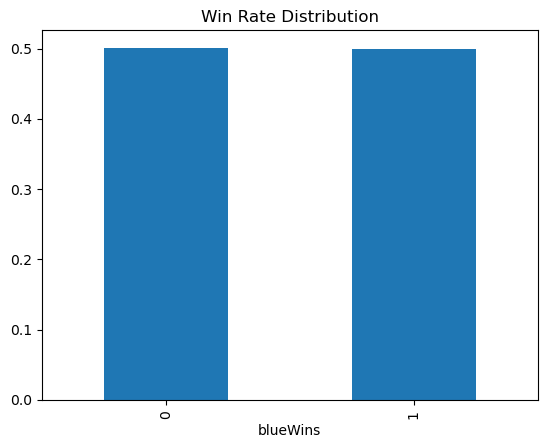

In [4]:
df['blueWins'].value_counts(normalize=True).plot(kind='bar', title='Win Rate Distribution')
plt.show()

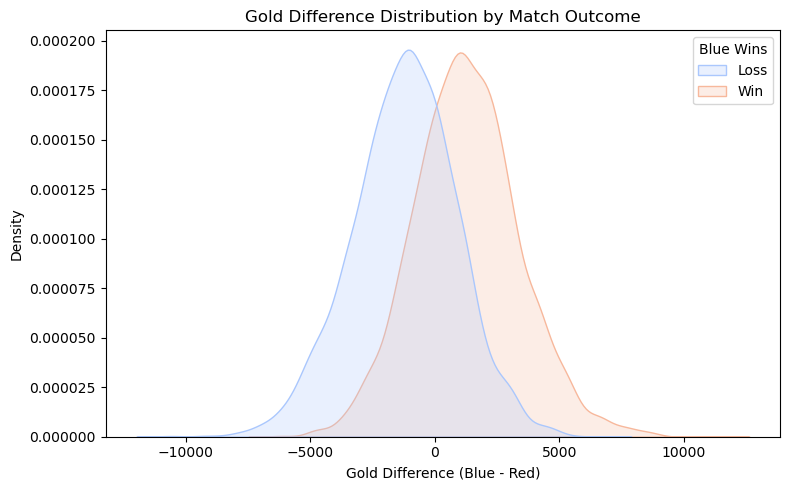

In [13]:
# distribution plot for blueGoldDiff
df['blueWinsLabel'] = df['blueWins'].map({0: 'Loss', 1: 'Win'})

plt.figure(figsize=(8,5))
plot = sns.kdeplot(data=df, x='blueGoldDiff', hue='blueWinsLabel', fill=True, common_norm=False, palette='coolwarm')
plt.title('Gold Difference Distribution by Match Outcome')
plt.xlabel('Gold Difference (Blue - Red)')
plt.ylabel('Density')
plot.legend_.set_title(title='Blue Wins')
plt.tight_layout()
plt.show()

df.drop(columns='blueWinsLabel', inplace=True)

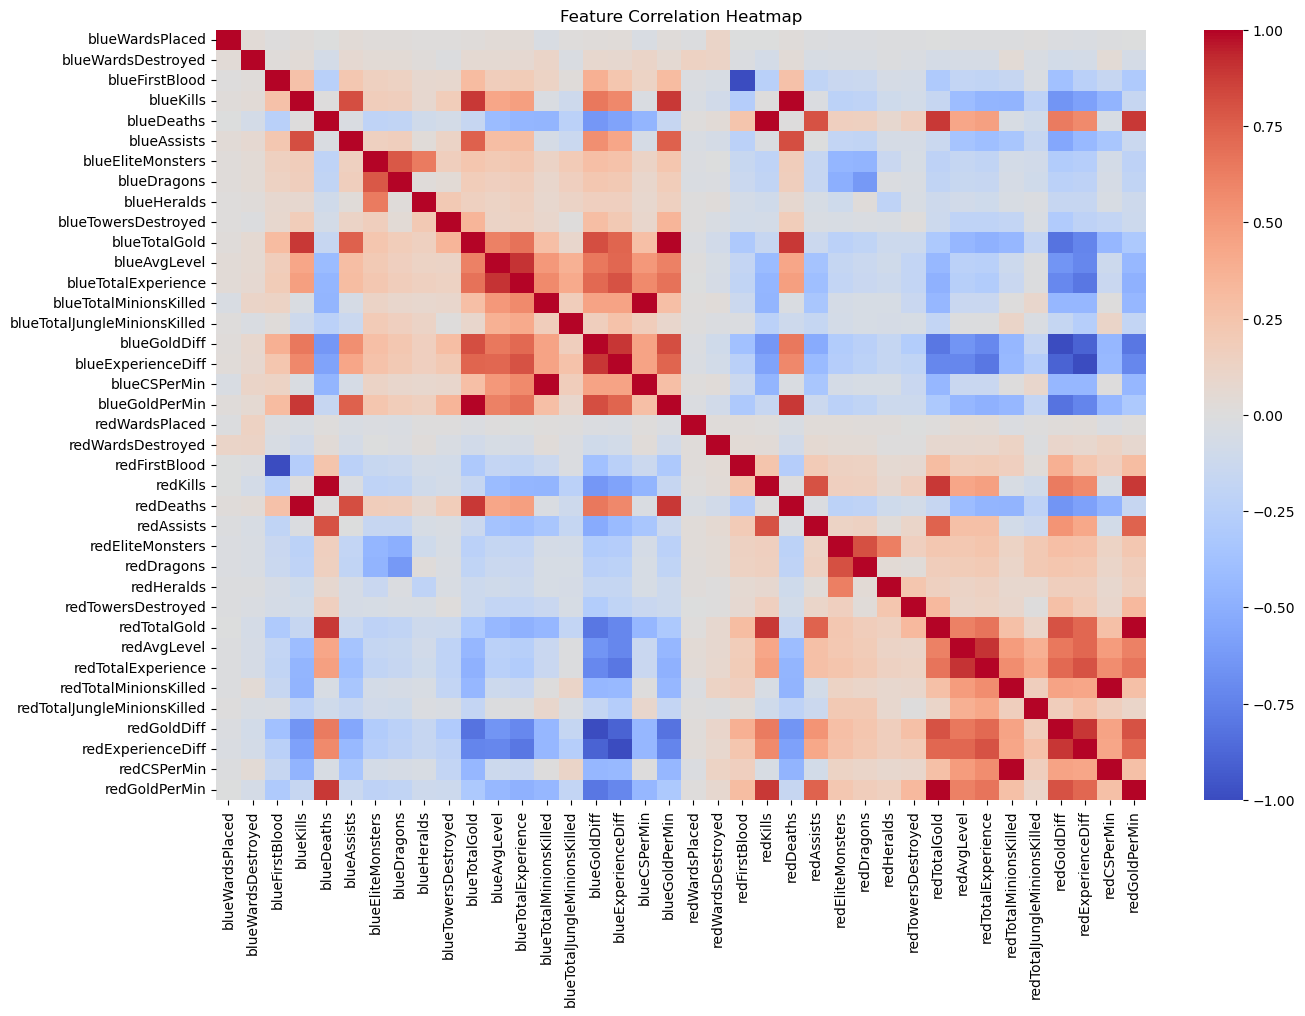

In [5]:
# drop target variable and useless identifier
df_features = df.drop(columns=['blueWins', 'gameId'])

plt.figure(figsize=(15, 10))
sns.heatmap(df_features.corr(), cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

### EDA结论：
- 数据中蓝方胜率大约接近50%，标签分布较为平衡。
- 金币差与比赛结果高度相关，可能是主要预测特征。
- 热力图显示部分特征间存在高相关性，后续需要进行特征选择。

## 3. Preprocessing & Feature Selection 

In [6]:
corr_matrix = df_features.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print("Highly correlated columns to drop:", to_drop)

Highly correlated columns to drop: ['blueCSPerMin', 'blueGoldPerMin', 'redFirstBlood', 'redKills', 'redDeaths', 'redGoldDiff', 'redExperienceDiff', 'redCSPerMin', 'redGoldPerMin']


In [7]:
# manual drop symmetric red-side features when blue-side or differential versions exist
manual_drop = [
    'blueTotalGold', 'redTotalGold',
    'blueTotalExperience', 'redTotalExperience',
    'blueKills', 'redKills',
    'blueAssists', 'redAssists',
    'blueEliteMonsters', 'redEliteMonsters'
]

# auto drop highly correlated feature pairs (correlation > 0.95)
auto_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

final_drop = list(set(manual_drop + auto_drop))
df_features = df_features.drop(columns=final_drop)

In [8]:
print("Remaining features:", df_features.columns.tolist())
print("Shape:", df_features.shape)

Remaining features: ['blueWardsPlaced', 'blueWardsDestroyed', 'blueFirstBlood', 'blueDeaths', 'blueDragons', 'blueHeralds', 'blueTowersDestroyed', 'blueAvgLevel', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueGoldDiff', 'blueExperienceDiff', 'redWardsPlaced', 'redWardsDestroyed', 'redDragons', 'redHeralds', 'redTowersDestroyed', 'redAvgLevel', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled']
Shape: (9879, 20)


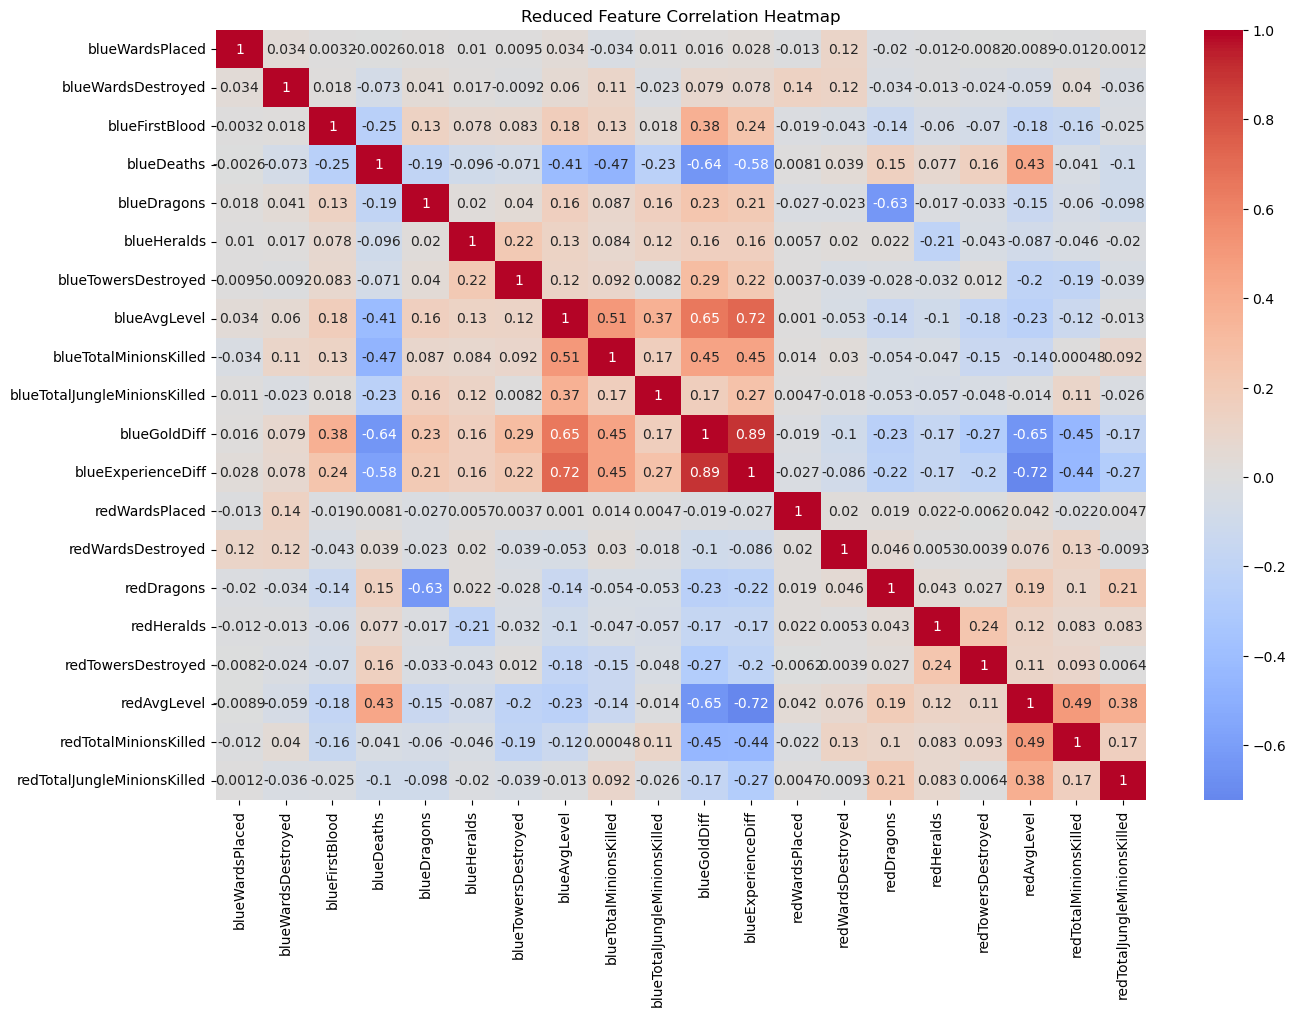

In [9]:
# plot remaining feature correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_features.corr(), cmap='coolwarm', center=0, annot=True)
plt.title("Reduced Feature Correlation Heatmap")
plt.show()

In [10]:
X = df_features
y = df['blueWins']

# scale the set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

## 4. Baseline Models  

使用的模型包括：逻辑回归、支持向量机、随机森林、K近邻、XGBoost。  
评估指标为准确率、精确率、召回率与F1分数。

In [11]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

In [12]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    results.append(result)

results_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.713563,0.710421,0.719067,0.714718
3,Support Vector Machine,0.716599,0.720954,0.704868,0.712821
1,Random Forest,0.716093,0.720665,0.703854,0.712160
4,XGBoost,0.702935,0.701312,0.704868,0.703085
2,K-Nearest Neighbors,0.673583,0.675592,0.665314,0.670414


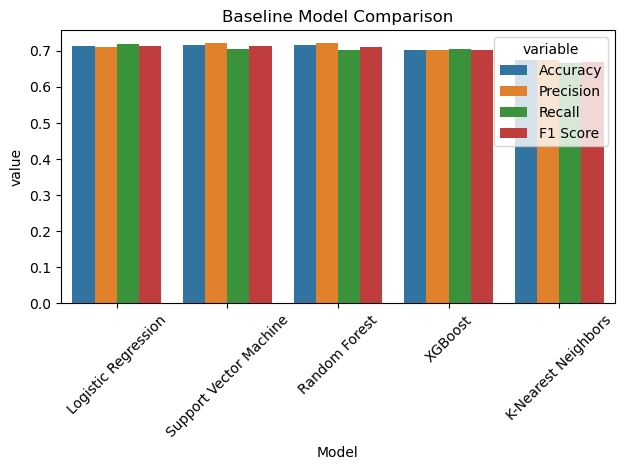

In [13]:
sns.barplot(data=results_df.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Baseline Model Comparison")
plt.xticks(rotation=45)
plt.tight_layout()

### 模型表现总结：
- 逻辑回归表现略优，但与XGBoost差距不大。
- 考虑到XGBoost具有更强的非线性建模能力及可解释性，我们选择对其进行后续调参和解释分析。

## 5. Model Optimization   

搜索参数包括：

- `learning_rate`: [0.01, 0.1, 0.2]  
- `max_depth`: [3, 5, 7]  
- `n_estimators`: [50, 100, 150]  
- `subsample`: [0.8, 1.0]

使用5折交叉验证，评价指标为F1分数。

In [15]:
param_grid = {
    'max_depth': [3, 5, 7],              
    'n_estimators': [50, 100, 150],      
    'learning_rate': [0.01, 0.1, 0.2],   
    'subsample': [0.8, 1.0],             
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best CV F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 1.0}
Best CV F1 Score: 0.7293635299298811


In [16]:
y_pred = best_model.predict(X_test)
print("Test F1 Score:", f1_score(y_test, y_pred))

Test F1 Score: 0.7171922685656155


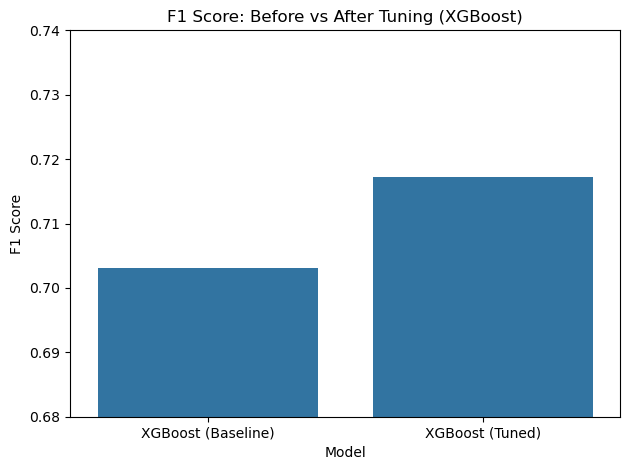

In [17]:
# Tuned XGBoost Performance
comparison = pd.DataFrame([
    {"Model": "XGBoost (Baseline)", "F1 Score": 0.7031},  
    {"Model": "XGBoost (Tuned)", "F1 Score": 0.7172}
])

sns.barplot(data=comparison, x="Model", y="F1 Score")
plt.title("F1 Score: Before vs After Tuning (XGBoost)")
plt.ylim(0.68, 0.74)
plt.tight_layout()
plt.show()

### 调参前后模型表现对比：
- 调参后模型在测试集上的F1分数提升约1.4%，说明超参数优化对模型有明显帮助。
- 最优模型使用较小的学习率和较浅的树深，避免了过拟合。

## 6. Model Interpretation  

使用SHAP库可视化特征重要性和单个样本的预测贡献。

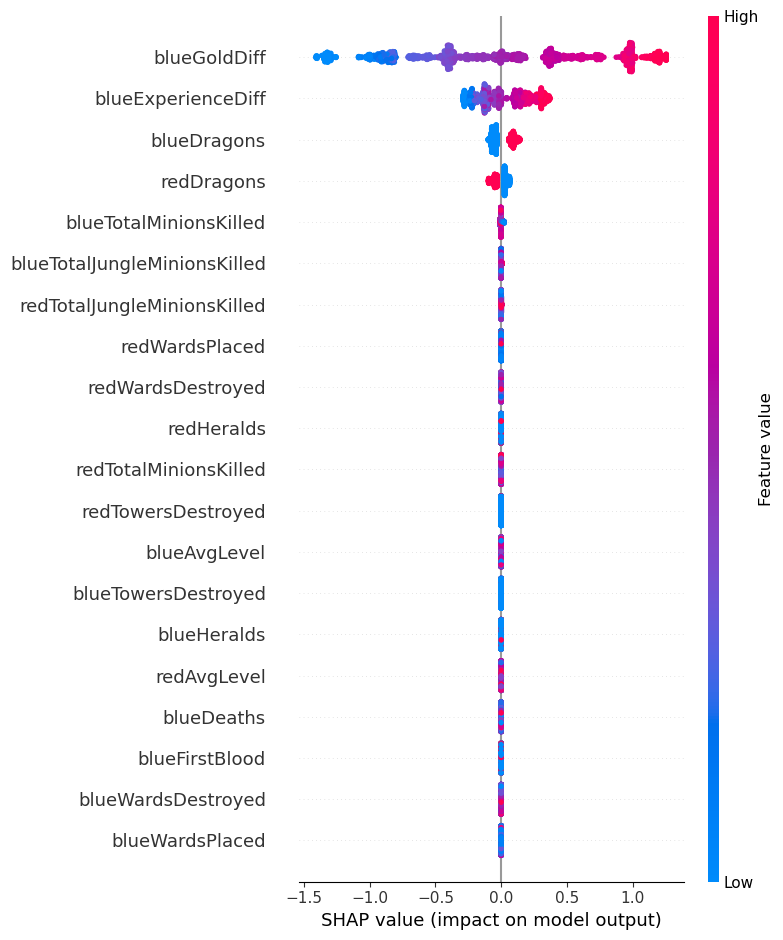

In [18]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Global summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [19]:
# Single example force plot
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_test[0], feature_names=X.columns)

### 分析结论：

- 金币差（`blueGoldDiff`）是最核心的预测特征，早期经济领先强烈影响比赛胜率。
- 经验差、击杀龙的数量也是重要因素。
- 插眼/排眼等视野类变量在10分钟时点对预测贡献较小，可能需要更长期的视野数据才能发挥作用。

## 7. Conclusion  
本项目基于英雄联盟比赛前10分钟的对局数据，构建模型预测比赛最终胜负。

### 主要结论：

- 金币和经验的领先情况是预测胜负的关键指标。
- 控制中立目标（例如小龙）对提升胜率有显著作用。
- XGBoost通过调参后取得了最佳表现（测试集F1分数约0.717）。
- SHAP可视化结果与游戏经验一致，验证了模型的可解释性。

### 后续优化方向

- 加入英雄选择、BP数据作为模型输入，考虑选角对胜率的影响。
- 扩展分析时间范围，引入全场时间序列数据，使用更复杂的时序模型。
